## Welcome to the Berry Easy Tutorial

In [3]:
pip install BerryEasy --upgrade

  Attempting uninstall: BerryEasy
    Found existing installation: BerryEasy 0.2.0
    Uninstalling BerryEasy-0.2.0:
      Successfully uninstalled BerryEasy-0.2.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Packages needed
from BerryEasy import BerryEasy as be
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Chern Insulator example

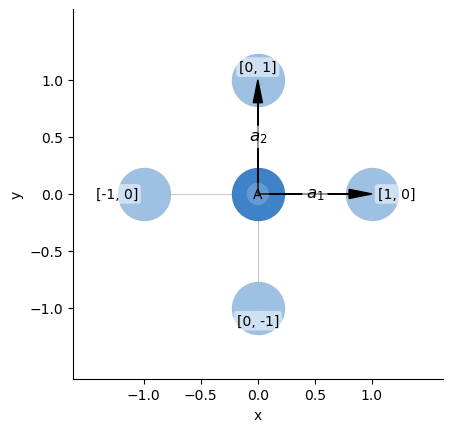

In [2]:
#Define Matrices:
g_1 = np.array([[0,1],[1,0]])
g_2 = np.array([[0,-1j],[1j,0]])
g_3 = np.diag([1,-1])

#Define hopping terms
U=-1.5*g_3
Tx=(1j*g_1+g_3)/2
Ty=(1j*g_2+g_3)/2
lat=pb.Lattice(a1=[1,0],a2=[0,1])
lat.add_sublattices(('A', [0,0],U))
lat.add_hoppings(                 
                 ([1,0], 'A', 'A', Tx),
                 ([0,1], 'A', 'A', Ty)
                )
lattice = lat
lattice.plot()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Unit_Cell.png')
plt.show()


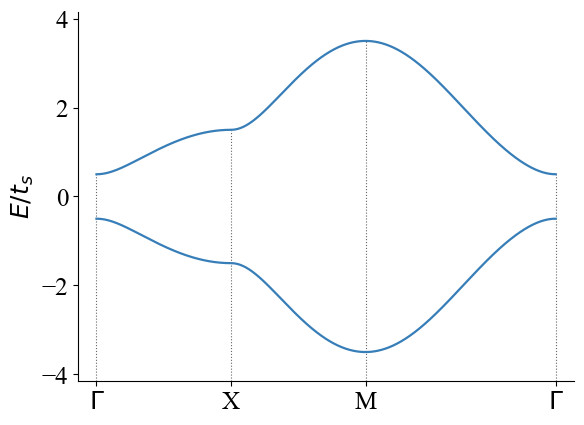

In [3]:
#Plot bandstructure
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
model = pb.Model(lat,
            pb.force_double_precision(),         
            pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)

from math import pi
X = [pi,0,0]
Gamma = [0,0,0]
M= [pi,pi,0]

bands = solver.calc_bands( Gamma, X, M, Gamma,step=0.01)
bands.plot(point_labels=[ r'$\Gamma$', 'X', 'M', r'$\Gamma$'])
plt.ylabel(r'$E/t_{s}$')
plt.xlabel('')
plt.savefig('Chern_Bands.png')

# Now let us begin computing topological invariants

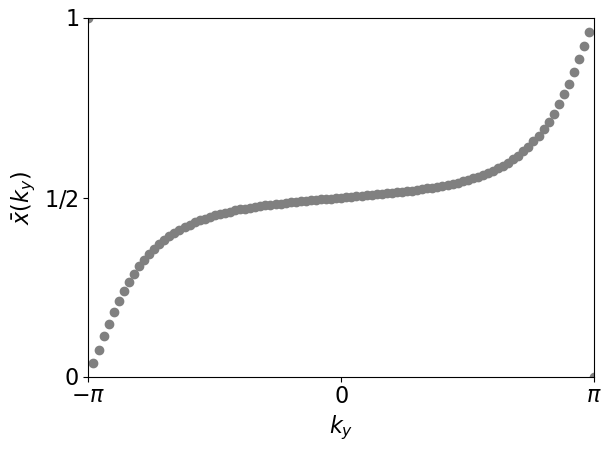

In [4]:
# Compute Wannier center charges along k_{x} direction as a function of transverse momenta k_{y}
vec=lambda t1, t2: [t1, t2, 0]
ds=100 #discretize integration into 100 steps
ds2=100 #consider 100 points along k_{y}
bnds=[0] #Occupied bands
rvec=2*np.pi*np.diag([1,1,1]) #Reciprocal lattice vectors
WCCx=be.WSurf(vec,model,bnds,ds,ds2,rvec)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(WCCx,'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,100)
plt.yticks([-pi,0,pi],[r'$0$',r'$1/2$',r'$1$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,50,100],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.ylabel(r'$\bar{x}(k_{y})$')
plt.tight_layout()
plt.savefig('Chern_WCC.png')

plt.show()

In [5]:
#Function to compute Chern number
def calc_chern(list):
    dkx=0
    res=[0]
    for j in range(np.shape(list)[0]-1):
        min=np.abs(list[j+1]-list[j])
        n=0
        if np.abs(list[j+1]-list[j]-2*np.pi)<min:
            n=-1
        if np.abs(list[j+1]-list[j]+2*np.pi)<min:
            n=1
        dkx=dkx+(list[j+1]-list[j]+n*2*np.pi)
        res.append(dkx)
    return dkx
        

In [6]:
dk=calc_chern(WCCx)
print(dk/(2*np.pi))

[1.00000011]


# Suppose we wish to observe Berry curvature in the plane. We can use a line instance to capture Berry flux through small plaquettes

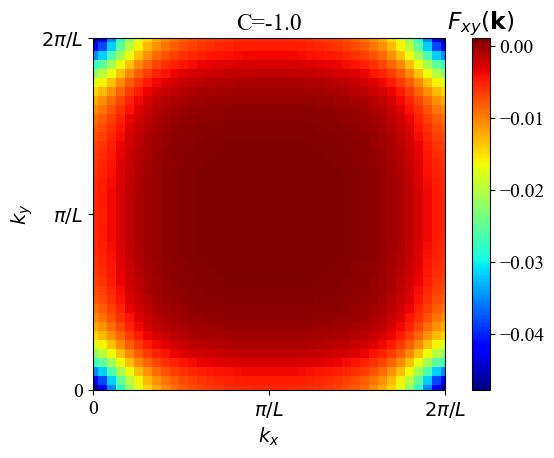

In [7]:
model = pb.Model(lat,
            pb.force_double_precision(),         
            pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)
L=1 # Lattice Constant
plaquettes=40 #Considering a 40x40 grid for computing Berry flux
rvec1=2*np.pi/L
rvec2=2*np.pi/L
dsx=((np.pi/L)/(plaquettes))
dsy=((np.pi/L)/(plaquettes))
kp1=np.linspace(dsx,rvec1-dsx,plaquettes)
kp2=np.linspace(dsy,rvec2-dsy,plaquettes)
bnds=range(L*L)
WCCtemp=[]
for kx in kp1:
    for ky in kp2:
        kpts=np.array([[kx-dsx,ky-dsy,0],[kx+dsx,ky-dsy,0],[kx+dsx,ky+dsy,0],[kx-dsx,ky+dsy,0]]) # define line for Wilson loop around plaquette
        WCCtemp.append(be.WLine(kpts,model,bnds))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
chern=[]
for j in range(np.shape(WCCtemp)[0]):
    chern.append(np.sum(WCCtemp[j]))
plt.imshow(np.array(chern).reshape(40,40),cmap='jet')
plt.ylabel(r'$k_{y}$')
plt.xlabel(r'$k_{x}$')
plt.xticks([0,19.5,39],[0,'$\pi/L$','$2\pi/L$'])
plt.yticks([0,19.5,39],[0,'$\pi/L$','$2\pi/L$'])
plt.xlim(0,39)
plt.ylim(0,39)

plt.title('C='+str(np.round(np.sum(chern)/(2*np.pi),3)))
clb = plt.colorbar()
clb.ax.set_title(r'$F_{xy}(\mathbf{k})$')
plt.tight_layout()
plt.show()

# Now let us consider the BHZ model of a spin hall insulator

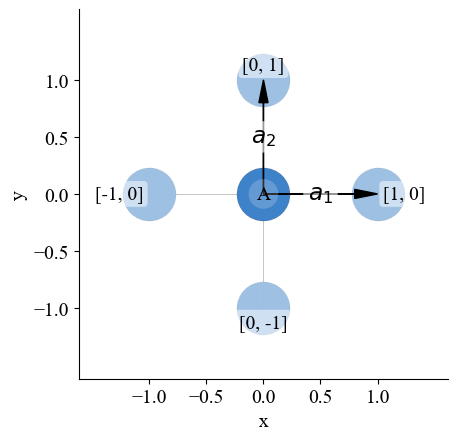

In [8]:
#Define Matrices:
g_1 = np.array([[0, 0, 0, 1], [0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]])
g_2 = np.array([[0,0,0, -1j], [0,0, 1j, 0],[0, -1j,0,0], [1j, 0,0,0]])
g_3 = np.array([[0, 0, 1, 0], [0, 0, 0, -1],[1, 0, 0, 0],[0, -1, 0, 0]])
g_4 = np.array([[0,0, -1j, 0], [0,0, 0,-1j],[1j,0,0,0], [0,1j,0,0]])
g_5 = np.diag([1,1,-1, -1])

U=-1.5*g_3
Tx=(1j*g_1+g_3)/2
Ty=(1j*g_2+g_3)/2
#Tz=(1j*g_3+g_5)/2
lat=pb.Lattice(a1=[1,0],a2=[0,1])
lat.add_sublattices(('A', [0,0],U))
lat.add_hoppings(                 
                 ([1,0], 'A', 'A', Tx),
                 ([0,1], 'A', 'A', Ty)
                )
lattice = lat
lattice.plot()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Unit_Cell.png')
plt.show()



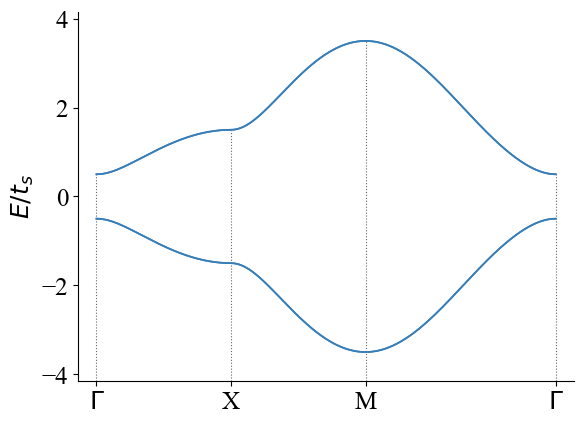

In [9]:
#Plot band structure, note bands are Kramers degenerate
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
model = pb.Model(lat,
            pb.force_double_precision(),         
            pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)

from math import pi
X = [pi,0,0]
Gamma = [0,0,0]
M= [pi,pi,0]

bands = solver.calc_bands( Gamma, X, M, Gamma,step=0.01)
bands.plot(point_labels=[ r'$\Gamma$', 'X', 'M', r'$\Gamma$'])
plt.ylabel(r'$E/t_{s}$')
plt.xlabel('')
plt.savefig('BHZ_Bands.png')

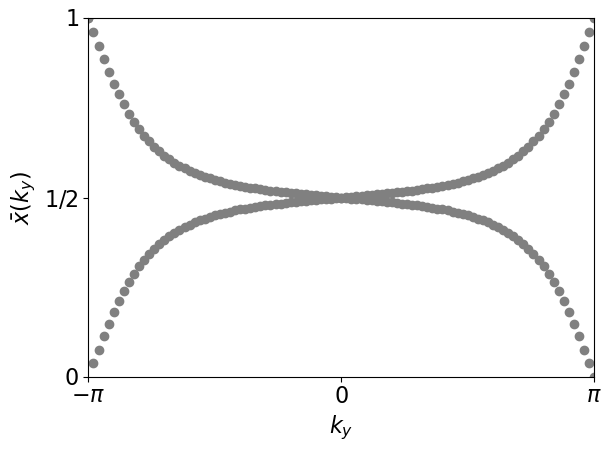

In [10]:
# Compute Wannier center charges along k_{x} direction as a function of transverse momenta
vec=lambda t1, t2: [t1, t2, 0]
ds=100
bnds=[0,1]
rvec=2*np.pi*np.diag([1,1,1])
WCCx=be.WSurf(vec,model,bnds,ds,ds,rvec)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(WCCx,'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,100)
plt.yticks([-pi,0,pi],[r'$0$',r'$1/2$',r'$1$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,50,100],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.ylabel(r'$\bar{x}(k_{y})$')
plt.tight_layout()
plt.savefig('BHZ_WCC.png')

plt.show()

# Now let us consider a chiral HOTI:

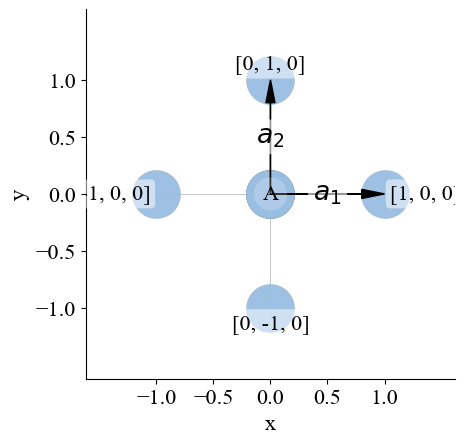

In [11]:


#Define Matrices:
g_1 = np.array([[0, 0, 0, 1], [0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]])
g_2 = np.array([[0,0,0, -1j], [0,0, 1j, 0],[0, -1j,0,0], [1j, 0,0,0]])
g_3 = np.array([[0, 0, 1, 0], [0, 0, 0, -1],[1, 0, 0, 0],[0, -1, 0, 0]])
g_4 = np.array([[0,0, -1j, 0], [0,0, 0,-1j],[1j,0,0,0], [0,1j,0,0]])
g_5 = np.diag([1,1,-1, -1])

U=-1.5*g_5
Tx=(1j*g_1+g_5+g_4)/2
Ty=(1j*g_2+g_5-g_4)/2
Tz=(1j*g_3+g_5)/2
lat=pb.Lattice(a1=[1,0,0],a2=[0,1,0],a3=[0,0,1])
lat.add_sublattices(('A', [0,0,0],U))
lat.add_hoppings(                 
                 ([1,0,0], 'A', 'A', Tx),
                 ([0,1,0], 'A', 'A', Ty),
    ([0,0,1], 'A', 'A', Tz)
                )
lattice = lat
lattice.plot()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Unit_Cell.png')
plt.show()



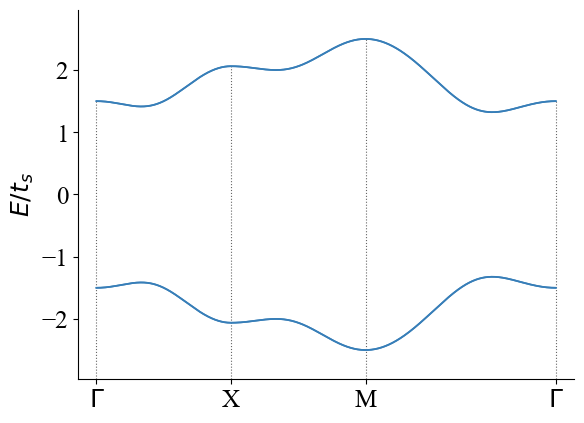

In [12]:
#Plot Bandstructure
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
model = pb.Model(lat,
            pb.force_double_precision(),         
            pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)

from math import pi
X = [pi,0,0]
Gamma = [0,0,0]
M= [pi,pi,0]

bands = solver.calc_bands( Gamma, X, M, Gamma,step=0.01)
bands.plot(point_labels=[ r'$\Gamma$', 'X', 'M', r'$\Gamma$'])
plt.ylabel(r'$E/t_{s}$')
plt.xlabel('')
plt.savefig('Chiral_HOTI_Bands.png')

# Compute Wannier center charges along $k_{x}$ direction as a function of transverse momenta at $k_{z}=0$

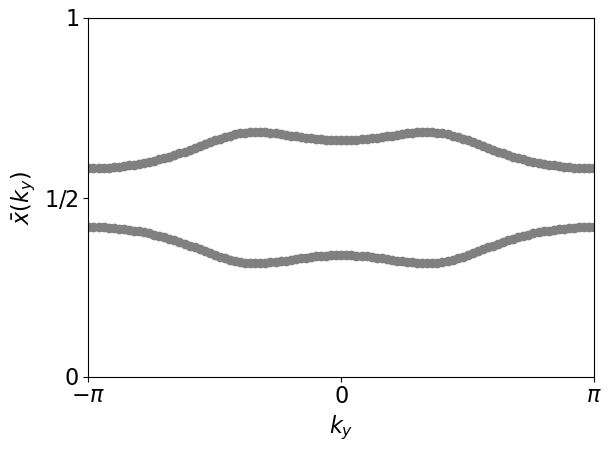

In [13]:



U=-1.5*g_5
Tx=(1j*g_1+g_5+g_4)/2
Ty=(1j*g_2+g_5-g_4)/2
Tz=(1j*g_3+g_5)
lat=pb.Lattice(a1=[1,0,0],a2=[0,1,0],a3=[0,0,1])
lat.add_sublattices(('A', [0,0],U))
lat.add_hoppings(                 
                 ([1,0,0], 'A', 'A', Tx),
                 ([0,1,0], 'A', 'A', Ty),
                ([0,0,1],'A','A',Tz)
                )
model = pb.Model(lat,
        pb.force_double_precision(),         
        pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)
vec=lambda t1, t2: [t1, t2, 0]
ds=100
rvec=2*np.pi*np.diag([1,1,1])
bnds=[0,1]
WCCx=be.WSurf(vec,model,bnds,ds,ds,rvec)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(WCCx,'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,100)
plt.yticks([-pi,0,pi],[r'$0$',r'$1/2$',r'$1$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,50,100],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.ylabel(r'$\bar{x}(k_{y})$')
plt.tight_layout()
plt.savefig('CH_WCC.png')

plt.show()

# Compute Nested Wilson loop in $k_{x}-k_{y}$ plane as a function of $k_{z}$

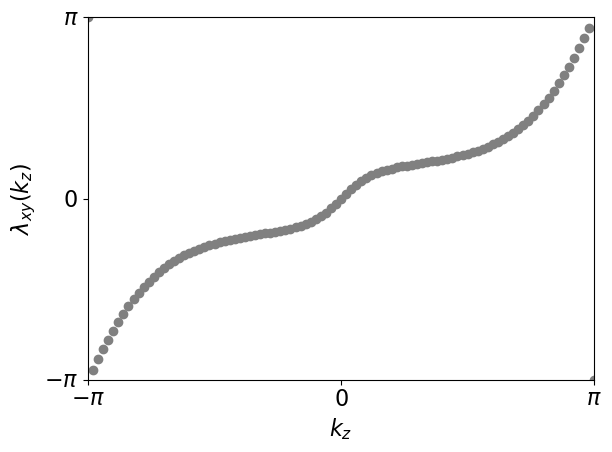

In [14]:

g_1 = np.array([[0, 0, 0, 1], [0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]])
g_2 = np.array([[0,0,0, -1j], [0,0, 1j, 0],[0, -1j,0,0], [1j, 0,0,0]])
g_3 = np.array([[0, 0, 1, 0], [0, 0, 0, -1],[1, 0, 0, 0],[0, -1, 0, 0]])
g_4 = np.array([[0,0, -1j, 0], [0,0, 0,-1j],[1j,0,0,0], [0,1j,0,0]])
g_5 = np.diag([1,1,-1, -1])
NWL=[]
ds=20
ds2=20
bnds=[0,1] #bands for construction of Wannier Hamiltonian
bnds2=[0] #bands of Wannier Hamiltonian being considered

U=-1.5*g_5
Tx=(1j*g_1+g_5+g_4)/2
Ty=(1j*g_2+g_5-g_4)/2
Tz=(1j*g_3+g_5)/2
lat=pb.Lattice(a1=[1,0,0],a2=[0,1,0],a3=[0,0,1])
lat.add_sublattices(('A', [0,0,0],U))
lat.add_hoppings(                 
                 ([1,0,0], 'A', 'A', Tx),
                 ([0,1,0], 'A', 'A', Ty),
                ([0,0,1], 'A', 'A', Tz)
                )
model = pb.Model(lat,
        pb.force_double_precision(),         
        pb.translational_symmetry(a1=True, a2=True,a3=True))
solver = pb.solver.lapack(model)
rvec=2*np.pi*np.diag([1,1,1])
for z in np.linspace(0,1,101):
    vec=lambda t1, t2: [t1, t2, z]
    WCCx=be.WNWL(vec,model,bnds,bnds2,ds,ds,rvec)
    NWL.append(WCCx)
plt.plot(np.array(NWL),'o',c='gray')
plt.ylim(-np.pi,np.pi)
plt.yticks([-np.pi,0,np.pi],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.xlabel(r'$k_{z}$')
plt.xlim(0,100)
plt.xticks([0,50,100],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.ylabel(r'$\lambda_{xy}(k_{z})$')
plt.tight_layout()
plt.savefig('ChiralHOTINWL.png')
plt.show()

# We saw that the WCC spectra was gapped, now let us consider the spin-resolved Wannier centers

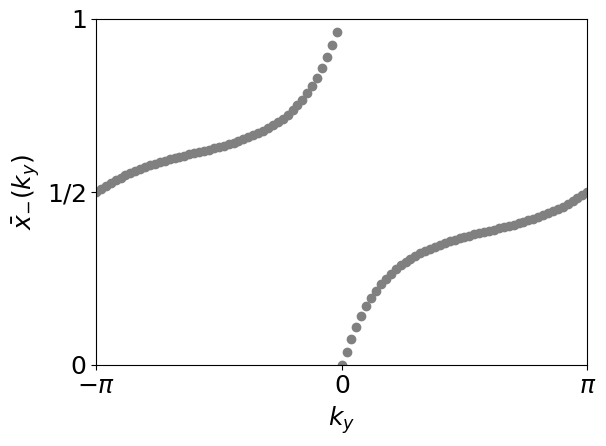

In [15]:

g_1 = np.array([[0, 0, 0, 1], [0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]])
g_2 = np.array([[0,0,0, -1j], [0,0, 1j, 0],[0, -1j,0,0], [1j, 0,0,0]])
g_3 = np.array([[0, 0, 1, 0], [0, 0, 0, -1],[1, 0, 0, 0],[0, -1, 0, 0]])
g_4 = np.array([[0,0, -1j, 0], [0,0, 0,-1j],[1j,0,0,0], [0,1j,0,0]])
g_5 = np.diag([1,1,-1, -1])
U=-1.5*g_5
Tx=(1j*g_1+g_5+g_4)/2
Ty=(1j*g_2+g_5-g_4)/2
Tz=(1j*g_3+g_5)
lat=pb.Lattice(a1=[1,0,0],a2=[0,1,0],a3=[0,0,1])
lat.add_sublattices(('A', [0,0,0],U))
lat.add_hoppings(                 
                 ([1,0,0], 'A', 'A', Tx),
                 ([0,1,0], 'A', 'A', Ty),
                ([0,0,1],'A','A',Tz)
                )
model = pb.Model(lat,
        pb.force_double_precision(),         
        pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)
vec=lambda t1, t2: [t1, t2, 0]
ds=100
ds2=100
bnds=[0,1]
S3=np.diag([1,-1])
op=np.kron(S3,S3) #Define Preferred Spin axis
rvec=2*np.pi*np.diag([1,1,1])
WCCx=be.WSpinSurf(vec,model,bnds,ds,ds2,op,rvec)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
plt.plot(WCCx,'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,100)
plt.yticks([-pi,0,pi],[r'$0$',r'$1/2$',r'$1$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,50,100],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.ylabel(r'$\bar{x}_{-}(k_{y})$')
plt.tight_layout()
plt.savefig('CH_WCC_SpinWL.png')

# Create PyBinding instance of bilayer-bismuth from Wannier90 output

In [16]:
import argparse
import pybinding as pb
import time
from tqdm import tqdm

#starttime = time.perf_counter()
#print("Starting calculation at ", end='')
#print(time.strftime("%H:%M:%S on %a %d %b %Y \n"))

# Command line praser
#----------------------------


lat = be.wan90_lat(0.05,100,"Bi")
pb.save(lat,"wtb_test.pbz")

#endtime = time.perf_counter()
#runtime = endtime-starttime
#print("\nEnd of calculation. ", end='')
#print("Program was running for %.2f seconds." % runtime)

Reading: Bi_tb.dat... 		done.
Reading: Bi_centres.xyz... 	done.
Converting on-site energyies: 


100%|██████████| 1639/1639 [00:00<00:00, 213155.07it/s]


Converting hopping energyies: 


100%|██████████| 1639/1639 [00:00<00:00, 3552.04it/s]


# Plot bands of tight-binding model

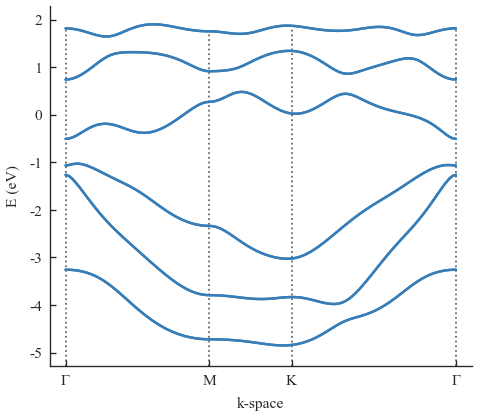

In [17]:

import pybinding as pb
from BerryEasy import BerryEasy as be
import numpy as np
import matplotlib.pyplot as plt
pb.pltutils.use_style()
# read-in lattice
lat = pb.load("wtb_test.pbz")

# construct model
model = pb.Model(lat, pb.translational_symmetry())

# use lapack solver
solver = pb.solver.lapack(model)

# get me recripocal vectors
rvec = np.array(lat.reciprocal_vectors())

# construct high symmetry points.
Gamma   = np.array([0,0,0])@rvec
M   = np.array([0.5,0,0])@rvec
K   = np.array([0.333,0.333,0])@rvec


bands = solver.calc_bands(Gamma, M, K, Gamma,  step=0.02)
bands.plot(point_labels=[r'$\Gamma$', 'M', 'K',r'$\Gamma$'])
plt.savefig('BiWTB_Bands.png')

# Compute Wannier center charges to demonstrate non-trivial $\mathbb{Z}_{2}$ index

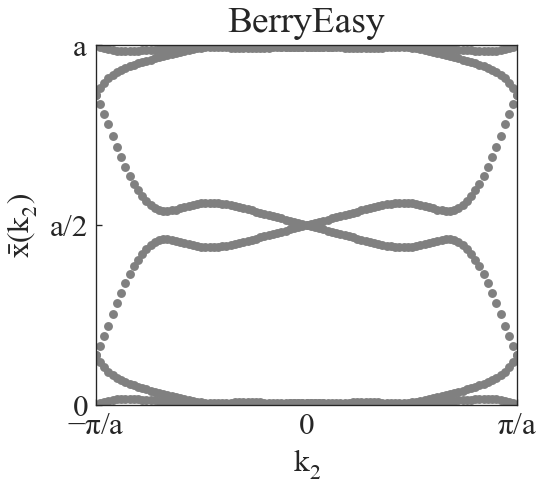

In [18]:
from math import pi
vec=lambda t1, t2: [t2, t1, 0]
ds=100
bnds=[0,1,2,3,4,5]
rvec = np.array(lat.reciprocal_vectors())
WCCx=be.WSurf(vec,model,bnds,ds,ds,rvec)
WCC2=[]
for i in range(101):
    for j in range(6):
        if WCCx[i][j]<0:
            WCC2.append(WCCx[i][j]+2*np.pi)
        else:
            WCC2.append(WCCx[i][j])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
plt.plot(np.array(WCC2).reshape(101,6),'.',c='gray')
plt.ylim(0,2*pi)
plt.xlim(0,100)
plt.yticks([0,pi,2*pi],[r'$0$',r'$a/2$',r'$a$'])
plt.xlabel(r'$k_{2}$')
plt.xticks([0,50,100],[r'$-\pi/a$',r'$0$',r'$\pi/a$'])
plt.ylabel(r'$\bar{x}(k_{2})$')
plt.title('BerryEasy')
plt.savefig('Bi_TB_WCC.png')

# Let us compare BerryEasy computations with that of Z2Pack


+----------------------------------------------------------------------+
| ===================                                                  |
| SURFACE CALCULATION                                                  |
| ===================                                                  |
| starting at 2024-01-05 14:47:09,073                                  |
| running Z2Pack version 2.2.0                                         |
|                                                                      |
| gap_tol:            0.3                                              |
| init_result:        None                                             |
| iterator:           range(50, 500, 100)                              |
| load:               False                                            |
| load_quiet:         True                                             |
| min_neighbour_dist: 0.01                                             |
| move_tol:           0.3                         

INFO: Adding line at t = 0.9400000000000001
INFO:       Calculating line for N = 50
INFO: Adding line at t = 0.9500000000000001
INFO:       Calculating line for N = 50
INFO: Adding line at t = 0.97
INFO:       Calculating line for N = 50
INFO: Adding line at t = 0.98
INFO:       Calculating line for N = 50
INFO: Adding line at t = 0.99
INFO:       Calculating line for N = 50
INFO: Adding line at t = 1.0
INFO:       Calculating line for N = 50
INFO: Convergence criteria fulfilled for 84 of 84 neighbouring lines.

+----------------------------------------------------------------------+
|                  Calculation finished in 0h 0m 49s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                         ==================                           |
|                         CONVERGENCE REPORT                           |
|                         ==================

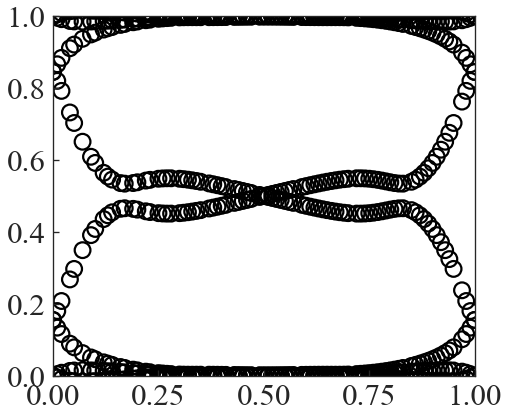

In [27]:

import z2pack
import tbmodels
model = tbmodels.Model.from_wannier_files(
    hr_file='Bi_hr.dat')
system = z2pack.tb.System(model, bands=6)

import logging
import itertools
import matplotlib.pyplot as plt

result = z2pack.surface.run(
        system=system,
        surface= lambda s,t: [t, s, 0],
        iterator=range(50,500,100),
        num_lines=101,
        pos_tol=None
    
    
    
)

z2pack.plot.wcc(result,gaps=False)   
plt.show()

# Plot Z2pack results, they are identical to Berry Easy results

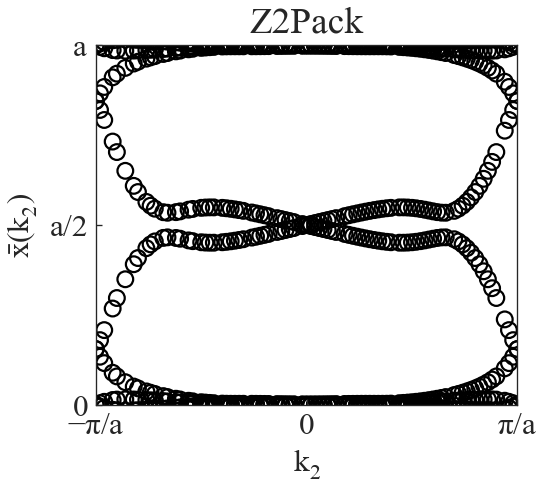

In [11]:

z2pack.plot.wcc(result,gaps=False)  
plt.xlabel(r'$k_{2}$')
plt.xticks([0,.5,1],[r'$-\pi/a$',r'$0$',r'$\pi/a$'])
plt.yticks([0,.5,1],[r'$0$',r'$a/2$',r'$a$'])

plt.ylabel(r'$\bar{x}(k_{2})$')
plt.title('Z2Pack')
plt.savefig('Bi_TB_WCC_Z2Pack.png')
plt.show()

# A non-trivial Z2 index indicates a non-trivial spin-Chern number: Here we compute the spin-Chern number directly 
# To compute the spin-resolved Wilson loop we must first identify the preferred spin direction for which the PSO is gapped
# This is accomplished using the spin_spectrum function

100%|██████████| 20/20 [00:00<00:00, 50.04it/s]


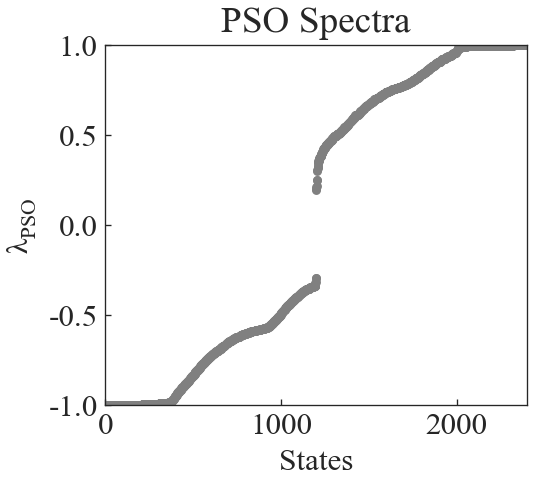

In [19]:
from tqdm import tqdm
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
model = pb.Model(lat,
            pb.force_double_precision(),         
            pb.translational_symmetry())
solver = pb.solver.lapack(model)
bnds=range(6)
op=np.diag([1,-1,-1,1,-1,1,-1,1,-1,1,1,-1]) #Preferred spin-direction
evf=[]
M1   = np.array([0.5,0,0])@rvec
M2   = np.array([0,0.5,0])@rvec
for i in tqdm(np.linspace(0,1,20)):
    for j in np.linspace(0,1,20):
        kpt=(M1*i+M2*j)
        evs=be.spin_spectrum(kpt[0],kpt[1],0,model,bnds,op)
        evf.append(evs)
plt.plot(np.sort(np.array(evf).flatten()),'.',c='gray')
plt.ylim(-1,1)
plt.ylabel(r'$\lambda_{PSO}$')
plt.xlim(0,int(400*6))
plt.title('PSO Spectra')
plt.xlabel('States')
plt.savefig('PSO_Spectra.png')
plt.show()

# Having verified that the PSO is gapped we proceed with computation of the spin-resolved WCCs

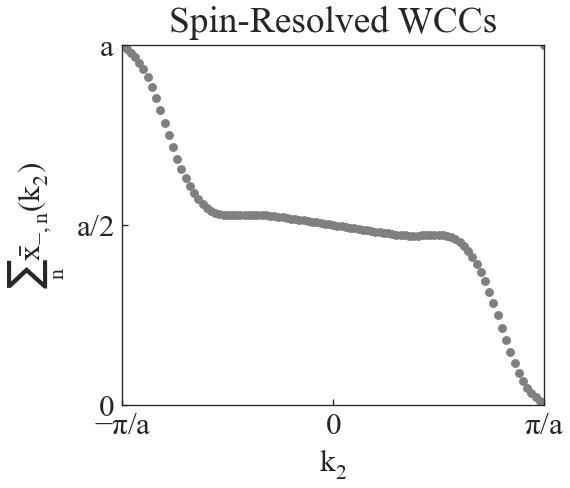

In [22]:
from math import pi
vec=lambda t1, t2: [t2, t1, 0]
ds=100
bnds=range(6)
rvec = np.array(lat.reciprocal_vectors())
WCCx=be.WSpinSurf(vec,model,bnds,ds,ds,op,rvec)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
plt.plot(np.sum(np.array(WCCx).reshape(101,3),1)%(2*np.pi),'.',c='gray')
plt.ylim(0,2*pi)
plt.xlim(0,20)
plt.yticks([0,pi,2*pi],[r'$0$',r'$a/2$',r'$a$'])
plt.xlabel(r'$k_{2}$')
plt.xticks([0,50,100],[r'$-\pi/a$',r'$0$',r'$\pi/a$'])
plt.ylabel(r'$\sum_{n}\bar{x}_{-,n}(k_{2})$')
plt.title('Spin-Resolved WCCs')
plt.savefig('Bi_SpinResolved_WCC.png')
plt.show()

# Now Let us consider a three-dimensional topological Type-II Dirac semimetal, PdTe2 as done in: Yan, M., Huang, H., Zhang, K. et al. Lorentz-violating type-II Dirac fermions in transition metal dichalcogenide PtTe2 . Nat Commun 8, 257 (2017).

# As a Dirac Semimetal, PdTe2 supports $\nu_{0}=+1$ in the $k_{z}=0$ plane and $\nu_{0}=0$ in the $k_{z}=\pi/a$ plane
# We compute the Z2 Invariant in each plane using WCCs to confirm this conclusion
# First we plot the band structure along the $Z- \Gamma - Z $ line to identify the Dirac Points

Reading: PdTe2_tb.dat... 		done.
Reading: PdTe2_centres.xyz... 	done.
Converting on-site energyies: 


100%|██████████| 1089/1089 [00:00<00:00, 217556.42it/s]


Converting hopping energyies: 


100%|██████████| 1089/1089 [00:01<00:00, 915.70it/s]


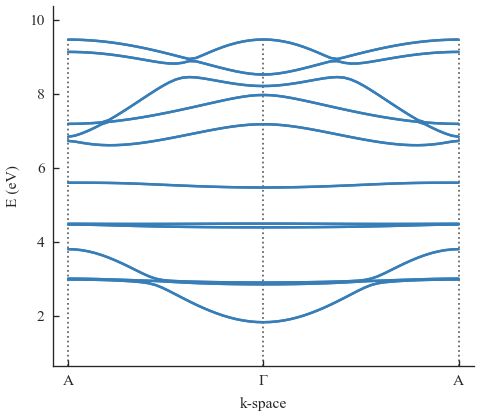

In [23]:
lat = be.wan90_lat(0.005,1000,"PdTe2")
pb.save(lat,"wtb_PdTe2.pbz")

import pybinding as pb
from BerryEasy import BerryEasy as be
import numpy as np
import matplotlib.pyplot as plt
pb.pltutils.use_style()
# read-in lattice
lat = pb.load("wtb_PdTe2.pbz")

# construct model
model = pb.Model(lat, pb.translational_symmetry())

# use lapack solver
solver = pb.solver.lapack(model)

# get me recripocal vectors
rvec = np.array(lat.reciprocal_vectors())

# construct high symmetry points.
Gamma   = np.array([0,0,0])@rvec
A   = np.array([0.0,0.0,0.5])@rvec


bands = solver.calc_bands(A, Gamma,  A,  step=0.02)
bands.plot(point_labels=['A',r'$\Gamma$', 'A'])
plt.savefig('PdTe2_WTB_Bands.png')

# We begin with $k_{z}=0$, the spectra is fully connected, i.e $\nu_{0}=+1$:

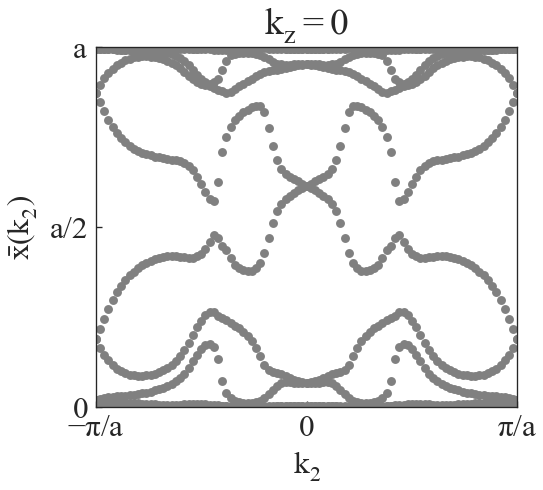

In [24]:
from math import pi
vec=lambda t1, t2: [t1, t2, 0]
ds=10
ds2=100
bnds=range(20)
rvec = np.array(lat.reciprocal_vectors())
WCCx=be.WSurf(vec,model,bnds,ds,ds2,rvec)
WCC3=[]
for i in range(101):
    for j in range(20):
        if WCCx[i][j]<0:
            WCC3.append(WCCx[i][j]+2*np.pi)
        else:
            WCC3.append(WCCx[i][j])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
#plt.plot(np.array(WCC2).reshape(201,10),'.',c='gray')
plt.plot(np.array(WCC3).reshape(101,20),'.',c='gray')
plt.ylim(0,2*pi)
plt.xlim(0,100)
plt.yticks([0,pi,2*pi],[r'$0$',r'$a/2$',r'$a$'])
plt.xlabel(r'$k_{2}$')
plt.xticks([0,50,100],[r'$-\pi/a$',r'$0$',r'$\pi/a$'])
plt.ylabel(r'$\bar{x}(k_{2})$')
plt.title(r'$k_{z}=0$')
plt.savefig('PdTe2_kz0_WCC.png')

# We begin with $k_{z}=\pi/a$, the spectra is gapped, i.e $\nu_{0}=0$:

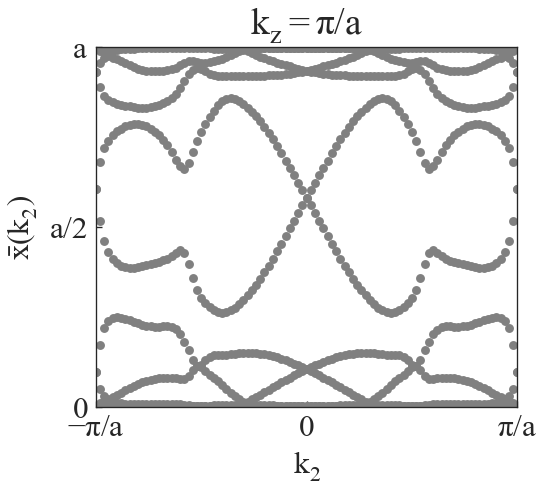

In [25]:
from math import pi
vec=lambda t1, t2: [t1, t2, 0.5]
ds=10
ds2=100
bnds=range(20)
rvec = np.array(lat.reciprocal_vectors())
WCCx=be.WSurf(vec,model,bnds,ds,ds2,rvec)
WCC3=[]
for i in range(101):
    for j in range(20):
        if WCCx[i][j]<0:
            WCC3.append(WCCx[i][j]+2*np.pi)
        else:
            WCC3.append(WCCx[i][j])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
#plt.plot(np.array(WCC2).reshape(201,10),'.',c='gray')
plt.plot(np.array(WCC3).reshape(101,20),'.',c='gray')
plt.ylim(0,2*pi)
plt.xlim(0,100)
plt.yticks([0,pi,2*pi],[r'$0$',r'$a/2$',r'$a$'])
plt.xlabel(r'$k_{2}$')
plt.xticks([0,50,100],[r'$-\pi/a$',r'$0$',r'$\pi/a$'])
plt.ylabel(r'$\bar{x}(k_{2})$')
plt.title(r'$k_{z}=\pi/a$')
plt.savefig('PdTe2_kzpi_WCC.png')